In [25]:
# make ploting inline of jupyter notebook
%matplotlib inline

In [26]:
# import necessary libraries
import matplotlib.pyplot as plt
from obspy import read, UTCDateTime, read_inventory, Stream, Trace
from obspy.signal.cross_correlation import correlation_detector
from obspy.signal.trigger import ar_pick
import os
import time
import numpy as np

In [27]:
'''
This function is used for plotting of the seismograms. It is not needed, since the obspy already has
this functionality, but since we will be adding some elements to the plot, it makes it more convinient.
'''

def mpl_plot(stream, figsize=[12.0, 8.0], linewidth=1):
    if len(stream)==1:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        ax.plot(stream[0].times("matplotlib"), stream[0].data, "k-", linewidth=linewidth, label=stream[0].stats.station+'.'+stream[0].stats.channel)
        ax.legend(loc=2)
    else:
        fig, ax = plt.subplots(nrows=len(stream), ncols=1, figsize=figsize)
        for i, tr in zip(range(0,len(stream)), stream):
            ax[i].plot(tr.times("matplotlib"), tr.data, "k-", linewidth=linewidth, label=tr.stats.station+'.'+tr.stats.channel)
            ax[i].legend(loc=2)

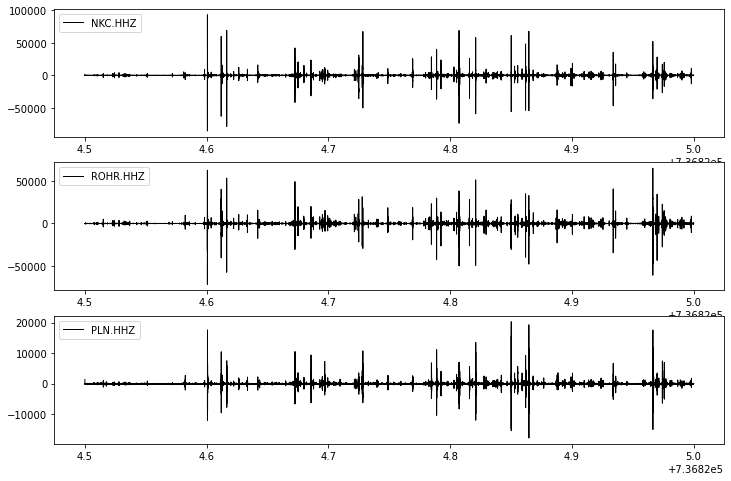

In [28]:
st = read('https://examples.obspy.org/NKC_PLN_ROHR.HHZ.2018.130.mseed')
st.filter('highpass', freq=1, zerophase=True)

mpl_plot(st)

In [29]:
otimes = [UTCDateTime('2018-05-10 14:24:50'), UTCDateTime('2018-05-10 19:42:08')]

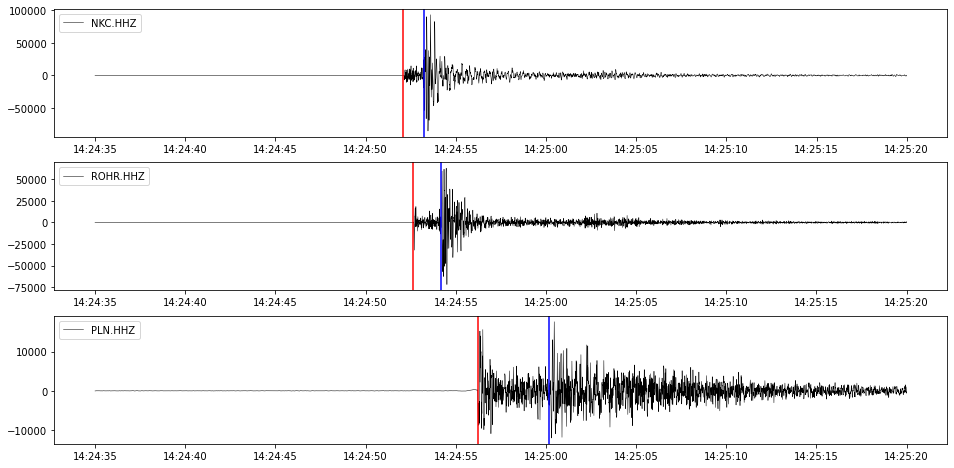

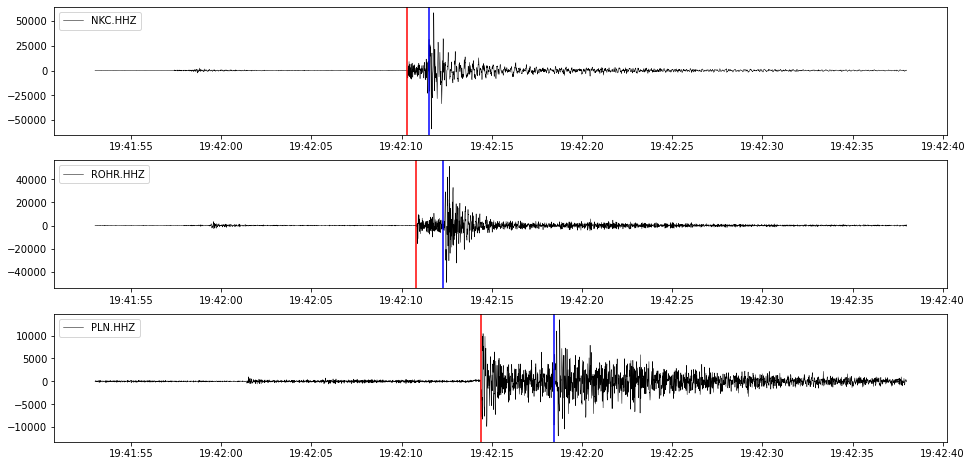

In [30]:
events_p = []
events_s = []

sttimes = []

for t in otimes:
    st_trim = st.copy().trim(t-15, t+30)
    sttimes.append(st_trim[0].stats.starttime)
    
    auto_detections_p = {}
    auto_detections_s = {}
    
    for tr in st_trim:
        df = st_trim[0].stats.sampling_rate
        p_pick, s_pick = ar_pick(tr.data, tr.data, tr.data, df,1.0, 30.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2)
        auto_detections_p[tr.stats.station] = p_pick
        auto_detections_s[tr.stats.station] = s_pick
    
    fig, ax = plt.subplots(nrows=len(st_trim), ncols=1, figsize=[16.0, 8.0])
    for i, tr in zip(range(0,len(st_trim)), st_trim):
        ax[i].plot(tr.times("matplotlib"), tr.data, "k-", linewidth=0.5, label=tr.stats.station+'.'+tr.stats.channel)
        ax[i].axvline((tr.stats.starttime+auto_detections_p[tr.stats.station]).datetime, c='r')
        ax[i].axvline((tr.stats.starttime+auto_detections_s[tr.stats.station]).datetime, c='b')
        ax[i].legend(loc=2)
        
    events_p.append(auto_detections_p)
    events_s.append(auto_detections_s)

In [31]:
templates = []
for event, sttime in zip(events_s, sttimes):
    templ = Stream()
    for key, value in event.items():
        templ+= st.select(station=key).slice((sttime+value)-2.5, (sttime+value)+2.5)
    templates.append(templ)
    print(templ)

template_magnitudes = [2.9, 2.8]
template_names = ['1st template', '2nd template']

3 Trace(s) in Stream:
CZ.NKC..HHZ  | 2018-05-10T14:24:50.738400Z - 2018-05-10T14:24:55.738400Z | 100.0 Hz, 501 samples
SX.ROHR..HHZ | 2018-05-10T14:24:51.700000Z - 2018-05-10T14:24:56.700000Z | 100.0 Hz, 501 samples
TH.PLN..HHZ  | 2018-05-10T14:24:57.689999Z - 2018-05-10T14:25:02.689999Z | 100.0 Hz, 501 samples
3 Trace(s) in Stream:
CZ.NKC..HHZ  | 2018-05-10T19:42:08.998400Z - 2018-05-10T19:42:13.998400Z | 100.0 Hz, 501 samples
SX.ROHR..HHZ | 2018-05-10T19:42:09.820000Z - 2018-05-10T19:42:14.820000Z | 100.0 Hz, 501 samples
TH.PLN..HHZ  | 2018-05-10T19:42:15.949999Z - 2018-05-10T19:42:20.949999Z | 100.0 Hz, 501 samples


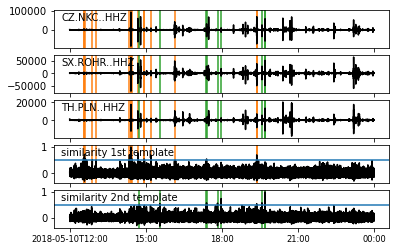

In [32]:
height = 0.5  # similarity threshold
distance = 6  # distance between detections in seconds

detections, sims = correlation_detector(st, templates, height, distance, template_names=template_names, plot=st)

In [33]:
print(len(detections))

25


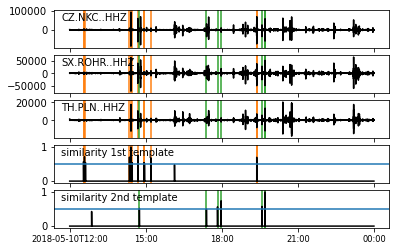

In [34]:
def similarity_component_thres(ccs, thres, num_components):
    """Return Trace with mean of ccs
    and set values to zero if number of components above threshold is not reached"""
    ccmatrix = np.array([tr.data for tr in ccs])
    header = dict(sampling_rate=ccs[0].stats.sampling_rate,
                  starttime=ccs[0].stats.starttime)
    comp_thres = np.sum(ccmatrix > thres, axis=0) >= num_components
    data = np.mean(ccmatrix, axis=0) * comp_thres
    return Trace(data=data, header=header)

def simf(ccs):
    return similarity_component_thres(ccs, 0.35, 3)

detections, sims = correlation_detector(
        st, templates, height, distance, similarity_func=simf, plot=st, template_magnitudes=template_magnitudes, template_names=template_names)